In [106]:
import os
import numpy as np
import fiona
import pandas as pd
import geopandas as gpd
import argparse
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from textwrap import wrap
from matplotlib.backends.backend_pdf import PdfPages
import json
with open('../process/configuration/cities.json') as f:
  city_data = json.load(f)


def valid_path(arg):
    arg = os.path.abspath(arg)
    if not os.path.exists(arg):
        msg = f"The path {arg} does not exist!"
        raise argparse.ArgumentTypeError(msg)
    else:
        return arg


In [216]:
# Parse input arguments
# parser = argparse.ArgumentParser(description='Generate origin destination matrix')
# parser.add_argument('-gpkg_cities',
#                     help='path to all cities summary results geopackage',
#                     default='./data/output/November 2020/global_indicators_city_2020-11-24.gpkg',
#                     type=valid_path)
# parser.add_argument('-gpkg_hexes',
#                     help='path to all cities hexagon grid results geopackage',
#                     default='./data/output/November 2020/global_indicators_hex_250m_2020-11-24.gpkg',
#                     type=valid_path)
# args = parser.parse_args()

# dummy parsing for interactive debugging
class Object(object):
    pass

args = Object()
args.gpkg_cities = os.path.abspath('../process/data/output/global_indicators_city_2020-11-24.gpkg')
args.gpkg_hexes = os.path.abspath('../process/data/output/global_indicators_hex_250m_2020-11-24.gpkg')

cities = gpd.read_file(args.gpkg_cities, layer='all_cities_combined')
cities.set_index('City',inplace=True)
# cities

In [217]:
hexes={}
for city in cities.index:
    hexes[city] = gpd.read_file(args.gpkg_hexes, layer=city.lower().replace(' ','_'))

In [218]:
hexes.keys()

dict_keys(['Maiduguri', 'Mexico City', 'Baltimore', 'Phoenix', 'Seattle', 'Sao Paulo', 'Hong Kong', 'Chennai', 'Bangkok', 'Hanoi', 'Adelaide', 'Melbourne', 'Sydney', 'Auckland', 'Graz', 'Ghent', 'Olomouc', 'Odense', 'Cologne', 'Lisbon', 'Barcelona', 'Valencia', 'Vic', 'Bern', 'Belfast'])

In [219]:
print("""
Global Indicators project, 2020

Analysis and mapping of threshold values for urban design and transport planning features associated with
  - (A) ≥80% probability of engaging in walking for transport and 
  - (B) reaching the WHO’s target of a ≥15% relative reduction in insufficient physical activity through walking

""")





Global Indicators project, 2020

Analysis and mapping of threshold values for urban design and transport planning features associated with
  - (A) ≥80% probability of engaging in walking for transport and 
  - (B) reaching the WHO’s target of a ≥15% relative reduction in insufficient physical activity through walking




In [220]:
# Analysis set up
scenarios={
  'A':'≥80% probability of engaging in walking for transport', 
  'B':'reaching the WHO’s target of a ≥15% relative reduction in insufficient physical activity through walking',
  'distances':'distances to destinations, measured up to a maximum distance target threshold of 500 metres'
}
scenario_style = {
    'A':{'colour':'lightcyan','line':'dashed'},
    'B':{'colour':'palegreen','line':'solid'},
    }
greq = '≥'
thresholds = {
'Mean 1000 m neighbourhood population per km²':{
  'data':'hexes', # the geopackage (hexes or points)
  'function':None, # optional function of multiple variables (row operation, ie. axis=1)
  'variable':'local_nh_population_density', # variable; a list is required if a function is specified
  'truncate_at_maximum':False, # distance measures are only formally measured up to 500m, however truncation at 500 is required for neatness due to full distance measurement method
  'polarity':'positive', # which is better: more (positive)? or less (negative)?
  'scenarios':{
      'A':{
        'threshold':5665, # not used; we plot the interval
        'comparison':'>', # direction in which to evaluate success (e.g. is the aim to be greater than or less than the threshold?)
        'interval':(4790, 6750),
        'interval_type':'95% CrI'
        },
      'B':{
        'threshold':6491,
        'comparison':'>',
        'interval':(5677, 7823),
        'interval_type':'95% CrI' 
        }
  }
},
'Mean 1000 m neighbourhood street intersections per km²':{
  'data':'hexes',
  'function':None, 
  'variable':'local_nh_intersection_density',
  'truncate_at_maximum':False,
  'polarity':'positive',
  'scenarios':{
      'A':{
        'threshold':98,
        'comparison':'>',
        'interval':(90, 110),
        'interval_type':'95% CrI'
        },
      'B':{
        'threshold':122,
        'comparison':'>',
        'interval':(106, 156),
        'interval_type':'95% CrI'
        }
  }
},
# 'Public transport density (stops/km2)':{
#   'data':'points',
#   'layer':'samplePointsData',
#   'function':none,
#   'variable':'',
#   'polarity':'positive',
#   'custom_density':{
#     'point_layer':'clean_intersections_12m',
#     'polygon_layer':'pop_ghs_2015',
#     'threshold':28,
#       'comparison':'>',
#     'interval':(23, max),
#     'interval_type':'95% CrI'
#     },
#   'B':{
#     'notes':'Not a significant correlate'
#     }
# },
'Distance to nearest public transport stops (m; up to 500m)':{
  'data':'points',
  'layer':'samplePointsData',
  'function':min, # take the minimum of the OSM and GTFS pt data sources
  'variable':['sp_nearest_node_pt_osm_any','sp_nearest_node_pt_gtfs_any'],
  'truncate_at_maximum':500,
  'polarity':'negative', # shorter distance is assumed to be better, so polarity is negative
  'scenarios':{
      'distances':{
        'interval':(0,150,200,300,400,500),
        'interval_type':'distance (m)',
        }
  }
},
'Distance to nearest park (m; up to 500m)':{
  'data':'points',
  'layer':'samplePointsData',
  'function':None,
  'variable':'sp_nearest_node_public_open_space_any',
  'truncate_at_maximum':500,
  'polarity':'negative',
  'scenarios':{
      'distances':{
        'interval':(0,150,200,300,400,500),
        'interval_type':'distance (m)',
        }
  }
}}



In [359]:
fontprops = fm.FontProperties(size=8)
for city in ['Maiduguri','Ghent']:
# for city in hexes.keys():
    print(city)
    study_region = cities.query(f'index=="{city}"').to_crs(hexes[city].crs).copy()
    width = (bounds['maxx'].values[0]-bounds['minx'].values[0])
    height = (bounds['maxy'].values[0]-bounds['miny'].values[0])
    # create a PdfPages object
    with PdfPages(f'reports/{city}_threshold_summary.pdf') as pdf:
        for indicator in thresholds.keys():
            data = thresholds[indicator]['data']
            variable = thresholds[indicator]['variable']
            indicator_scenarios = list(thresholds[indicator]['scenarios'].keys())
            polarity = thresholds[indicator]['polarity']
            # adjust colour scales for indicator polarities (more blue is better, or meeting achievements)
            if polarity == 'negative':
                cmap = 'viridis'
                cmap_r = 'virids_r'
            else:
                cmap = 'viridis_r'
                cmap_r = 'viridis'
            
            # Process maps for indicators using the hex data
            if data == 'hexes':
                if thresholds[indicator]['function'] != None:
                    hexes[city]['derived']=hexes[city][variable].apply(lambda x: thresholds[indicator]['function'](x),axis=1)
                    variable = 'derived'
                
                if thresholds[indicator]['truncate_at_maximum']!=False:
                    cutoff = thresholds[indicator]['truncate_at_maximum']
                    hexes[city].loc[hexes[city][variable]>cutoff,variable] = np.nan
                
                var_min = min(hexes[city][variable])        
                var_max = max(hexes[city][variable])
                
                # map main indicator
                fig, ax = plt.subplots(1, 1, figsize=(11.69,8.27))
                ax.set_aspect('equal')
                study_region.plot(ax=ax, color='none', edgecolor='black',zorder=2)
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="5%", pad=0.1)
                ax.set_xticks([])
                ax.set_yticks([])

                scalebar = AnchoredSizeBar(ax.transData,
                                           1000, '1000 m', 'lower right', 
                                           pad= .01,
                                           color='black',
                                           frameon=False,
                                           fontproperties=fontprops)

                ax.add_artist(scalebar)
                fig.suptitle("\n".join(wrap(indicator, 120 )))
                hexes[city].plot(column=variable, ax=ax, legend=True, cax=cax, cmap=cmap, zorder=1)
                ax.set_rasterized(True)
                pdf.savefig(fig,dpi=200)
                plt.clf()

                # map scenarios using custom splits
                interval_splits ={}
                splits = {}
                for scenario in [s for s in scenarios.keys() if s in indicator_scenarios]:
                    attributes = list(thresholds[indicator]['scenarios'][scenario].keys())
                    if ('interval' in attributes):
                        splits[scenario] = thresholds[indicator]['scenarios'][scenario]['interval']
                        interval_type = thresholds[indicator]['scenarios'][scenario]['interval_type']
                        if max in splits:
                            splits[scenario] = [x if x!=max else var_max for x in splits[scenario]]
                        if min in splits:
                            splits[scenario] = [x if x!=min else min(hexes[city][variable]) for x in splits[scenario]]
                        interval_splits[scenario] = list(splits[scenario]).copy()
                        split_labels = [f'within {interval_type} {splits[scenario]}']
                        if var_min < splits[scenario][0]:
                            splits[scenario] = [var_min]+list(splits[scenario])
                            split_labels = [f'below {interval_type} lower bound']+split_labels
                        if var_max > splits[scenario][-1]:
                            splits[scenario] = list(splits[scenario])+[var_max]
                            split_labels = split_labels+[f'exceeds {interval_type} upper bound']
                        #print(splits)
                        hexes[city][f'{variable}_{scenario}'] = pd.cut(hexes[city][variable], bins=splits[scenario], labels=split_labels)
                        hexes[city][f'{variable}_{scenario}']
                        fig, ax = plt.subplots(figsize=(11.69,8.27))
                        ax.set_aspect('equal')
                        study_region.plot(ax=ax, color='none', edgecolor='black', zorder=2)
                        ax.set_xticks([])
                        ax.set_yticks([])
                        scalebar = AnchoredSizeBar(ax.transData,
                                                   1000, '1000 m', 'lower right', 
                                                   pad= .01,
                                                   color='black',
                                                   frameon=False,
                                                   fontproperties=fontprops)
                        ax.add_artist(scalebar)
                        fig.suptitle("\n".join(wrap(f'Estimated {indicator} requirement for {scenarios[scenario]}', 120 )))
                        if 'notes' in attributes:
                            ax.set_title(f"{thresholds[indicator]['scenarios'][scenario]['notes']}")
                        
                        hexes[city].plot(column = f'{variable}_{scenario}',ax=ax,legend=True,cmap=cmap, zorder=1,legend_kwds={'borderaxespad':-4-height**.001, 'loc':'lower center'})
                        ax.set_rasterized(True)
                        pdf.savefig(fig, dpi=200)
                        plt.clf()
                
                hexes[city][f'{variable}'].hist(grid=False)
                plt.suptitle("\n".join(wrap(f'Histogram of {indicator}.',120)))
                
                subtitle = ''
                
                for scenario in [s for s in scenarios.keys() if s in indicator_scenarios]:
                    attributes = list(thresholds[indicator]['scenarios'][scenario].keys())
                    if ('interval' in attributes):
                        subtitle = subtitle+(f'Target threshold of {thresholds[indicator]["scenarios"][scenario]["threshold"]} '
                                             f'({interval_type} {thresholds[indicator]["scenarios"][scenario]["interval"]};{scenario_style[scenario]["colour"]}, {scenario_style[scenario]["line"]}).')
                        for line in splits[scenario][1:]:
                            plt.axvline(line, color='k', linestyle=scenario_style[scenario]["line"], linewidth=1)
                        plt.axvspan(*interval_splits[scenario], color=scenario_style[scenario]["colour"],alpha=0.6, zorder=0)
                if subtitle!='':
                    plt.title("\n".join(wrap(subtitle,120)))
                
                pdf.savefig(fig)
                plt.clf()
            
            # Process maps for indicators using the point data (e.g. distances)
            if data == 'points':
                layer = thresholds[indicator]['layer']
                points = gpd.read_file(f"../process/data/output/{city_data['gpkgNames'][city.lower().replace(' ','_')]}",layer=layer)
                if thresholds[indicator]['function'] != None:
                    points['derived']=points[variable].apply(lambda x: thresholds[indicator]['function'](x.fillna(value=np.nan)),axis=1)
                    variable = 'derived'
                
                if thresholds[indicator]['truncate_at_maximum']!=False:
                    cutoff = thresholds[indicator]['truncate_at_maximum']
                    points.loc[points[variable]>cutoff,variable] = np.nan
                
                var_min = min(points[variable])        
                var_max = max(points[variable])
                
                # map main indicator
                fig, ax = plt.subplots(1, 1, figsize=(11.69,8.27))
                ax.set_aspect('equal')
                study_region.plot(ax=ax, color='none', edgecolor='black',zorder=2)
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="5%", pad=0.1)
                ax.set_xticks([])
                ax.set_yticks([])

                scalebar = AnchoredSizeBar(ax.transData,
                                           1000, '1000 m', 'lower right', 
                                           pad= .01,
                                           color='black',
                                           frameon=False,
                                           fontproperties=fontprops)

                ax.add_artist(scalebar)
                fig.suptitle("\n".join(wrap(indicator, 120 )))
                points.plot(column=variable, ax=ax, legend=True, cax=cax, cmap=cmap,markersize=0.5, zorder=1)
                ax.set_rasterized(True)
                pdf.savefig(fig, dpi=200)
                plt.clf()

                # map scenarios using custom splits
                interval_splits ={}
                splits = {}
                for scenario in [s for s in scenarios.keys() if s in indicator_scenarios and s!='distances']:
                    attributes = list(thresholds[indicator]['scenarios'][scenario].keys())
                    threshold = thresholds[indicator]['scenarios'][scenario]['threshold']
                    comparison = thresholds[indicator]['scenarios'][scenario]['comparison']
                    if ('interval' in attributes):
                        splits[scenario] = thresholds[indicator]['scenarios'][scenario]['interval']
                        interval_type = thresholds[indicator]['scenarios'][scenario]['interval_type']
                        if max in splits:
                            splits[scenario] = [x if x!=max else var_max for x in splits[scenario]]
                        if min in splits:
                            splits[scenario] = [x if x!=min else min(points[variable]) for x in splits[scenario]]
                        interval_splits[scenario] = list(splits[scenario]).copy()
                        if scenario == 'custom density':
                            split_labels = [f'within {interval_type} {splits[scenario]}']
                            if var_min < splits[scenario][0]:
                                splits[scenario] = [var_min]+list(splits[scenario])
                                split_labels = [f'below {interval_type} lower bound']+split_labels
                            if var_max > splits[scenario][-1]:
                                splits[scenario] = list(splits[scenario])+[var_max]
                                split_labels = split_labels+[f'exceeds {interval_type} upper bound']
                        else:
                            split_labels = None
                        #print(splits)
                        points[f'{variable}_{scenario}'] = pd.cut(points[variable], bins=splits[scenario], labels=split_labels)
                        points[f'{variable}_{scenario}']
                        fig, ax = plt.subplots(figsize=(11.69,8.27))
                        ax.set_aspect('equal')
                        study_region.plot(ax=ax, color='none', edgecolor='black', zorder=2)
                        ax.set_xticks([])
                        ax.set_yticks([])
                        scalebar = AnchoredSizeBar(ax.transData,
                                                   1000, '1000 m', 'lower right', 
                                                   pad= .01,
                                                   color='black',
                                                   frameon=False,
                                                   fontproperties=fontprops)
                        ax.add_artist(scalebar)
                        fig.suptitle("\n".join(wrap(f'Estimated {indicator} requirement for {scenarios[scenario]}', 120 )))
                        if 'notes' in attributes:
                            ax.set_title(f"{thresholds[indicator]['scenarios'][scenario]['notes']}")
                        
                        points.plot(column = f'{variable}_{scenario}',ax=ax,legend=True,cmap=cmap, zorder=1,legend_kwds={'borderaxespad':-4-height**.001, 'loc':'lower center'})
                        ax.set_rasterized(True)
                        pdf.savefig(fig)
                        plt.clf()
                
                # Plot histogram (not for distances, as truncation at 500m with otherwise nans is misleading in basic histogram)
                if 'distances' not in list(thresholds[indicator]["scenarios"].keys()):
                    points[f'{variable}'].hist(grid=False)
                    plt.suptitle("\n".join(wrap(f'Histogram of {indicator}.',120)))

                    subtitle = ''
                    scenario_style = {'A':{'colour':'lightcyan','line':'dashed'},'B':{'colour':'palegreen','line':'solid'}}
                    for scenario in [s for s in scenarios.keys() if s in indicator_scenarios]:
                        attributes = list(thresholds[indicator]['scenarios'][scenario].keys())
                        if ('interval' in attributes):
                            subtitle = subtitle+(f'\r\n{interval_type} {thresholds[indicator]["scenarios"][scenario]["interval"]};{scenario_style[scenario]["colour"]}, {scenario_style[scenario]["line"]}')
                            for line in splits[scenario][1:]:
                                plt.axvline(line, color='k', linestyle=scenario_style[scenario]["line"], linewidth=1)
                            plt.axvspan(*interval_splits[scenario], color=scenario_style[scenario]["colour"],alpha=0.6, zorder=0)
                    if subtitle!='':
                        plt.title("\n".join(wrap(subtitle,120)))

                    pdf.savefig(fig)
                    plt.clf()


Maiduguri
Ghent


<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

<Figure size 841.68x595.44 with 0 Axes>

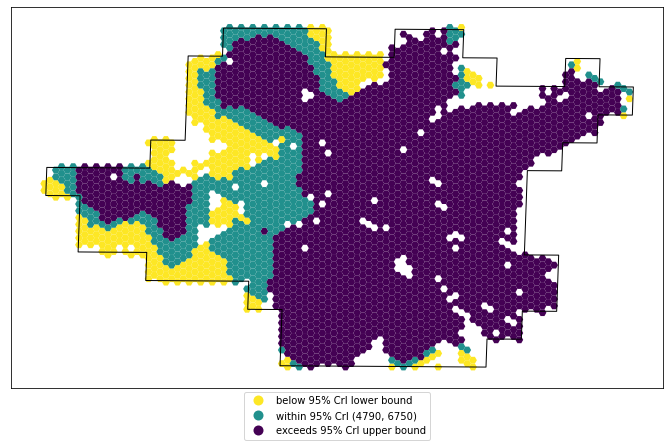

<Figure size 432x288 with 0 Axes>

In [358]:
# sketch attempt to increase map size by 10% to allow more space for legend
city = 'Maiduguri'
study_region = cities.query(f'index=="{city}"').to_crs(hexes[city].crs).copy()
bounds = study_region.bounds
width = (bounds['maxx'].values[0]-bounds['minx'].values[0])
height = (bounds['maxy'].values[0]-bounds['miny'].values[0])
padding_degree = 0.2
x_legend_padding = (bounds['minx'].values[0]-width*padding_degree,bounds['maxx'].values[0]+width*padding_degree)
y_legend_padding = (bounds['miny'].values[0]-0.4*height*padding_degree,bounds['maxy'].values[0]+1.4*height*padding_degree)
fig, ax = plt.subplots(figsize=(11.69,8.27))
ax.set_aspect('equal')
study_region.plot(ax=ax, color='none', edgecolor='black', zorder=2)
ax.set_xticks([])
ax.set_yticks([])
#ax.set(xlim=(bounds['minx']-width/20.0,bounds['maxx']+width/20.0), ylim=(bounds['miny']-height/20.0,bounds['maxy']+height/20.0)) 
hexes[city].plot(column = 'local_nh_population_density_A',ax=ax,legend=True,cmap='viridis_r', zorder=1,legend_kwds={'borderaxespad':-4.2-height**.001, 'loc':'lower center'})
# ax.set_xlim(x_legend_padding)
# ax.set_ylim(y_legend_padding)
# plt.legend(borderaxespad = 0.5)
# plt.subplots_adjust(hspace=100000)
ax.set_rasterized(True)
plt.show()
# plt.savefig(f'test_{city}_padding.pdf')
plt.clf()

In [208]:
# Estimated percentage of population meeting indicator threshold
indicator = 'Mean 1000 m neighbourhood population per km²'
variable = thresholds[indicator]['variable']
for scenario in thresholds[indicator]['scenarios']:
threshold = thresholds[indicator]['scenarios'][scenario]['threshold']
comparison = thresholds[indicator]['scenarios'][scenario]['comparison']
100*hexes['Maiduguri'].groupby([hexes['Maiduguri'].eval(f"{variable}{comparison}{threshold}")])['pop_est'].sum().loc[True]/hexes['Maiduguri']['pop_est'].sum()

95.92969419026657

In [325]:
height**.05

1.6470920010178893

In [178]:
# Estimated percentage of population with access within 500 metres estimates
cities.query('City=="Maiduguri"')[['pop_pct_access_500m_public_open_space_any_binary','pop_pct_access_500m_pt_any_binary']].transpose()

,0
pop_pct_access_500m_public_open_space_any_binary,1.913278
pop_pct_access_500m_pt_any_binary,9.571100
